In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
print(cv2.__version__)

plt.rc('image', cmap='gray') # set the default color-map of plt.image() to 'gray'
plt.rc('figure', figsize=[10,10]) # set a bigger default figure size

4.4.0


# Getting video

-1

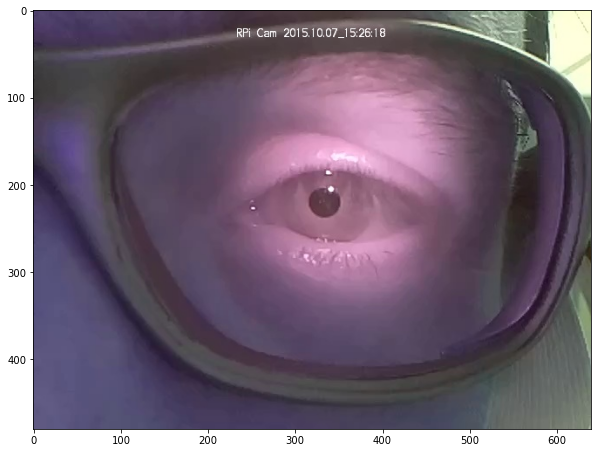

In [2]:
cap = cv2.VideoCapture('P5_eyeTracking.mp4')
ret, F0 = cap.read()
while True:
    ret, frame = cap.read() # read next frame
    if ret==True:
        cv2.imshow('Original Eye Tracking Video', frame)    
        if (cv2.waitKey(1) & 0xff == 27): # ESC key pressed?
            break
    else:
        break

#First frame of the original video        
cv2.imwrite('first_frame.jpg', F0)
first_frame = cv2.imread('first_frame.jpg')
plt.imshow(first_frame)

cap.release() # release input video
cv2.destroyAllWindows() # delete output window
cv2.waitKey(1)


# Video stabilization

-1

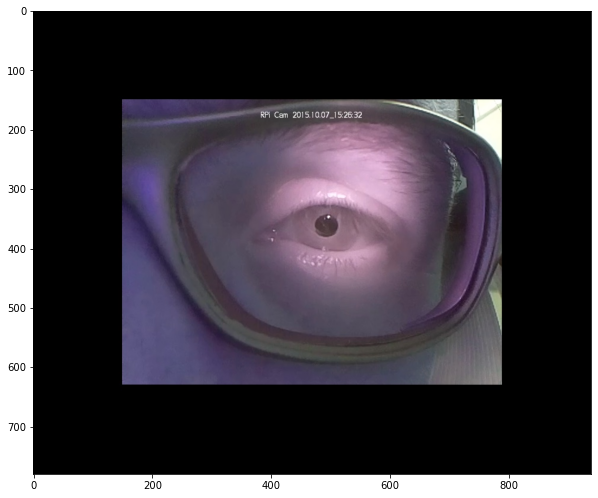

In [3]:
N = 150
cap = cv2.VideoCapture('P5_eyeTracking.mp4')
sift = cv2.xfeatures2d.SIFT_create()
bf = cv2.BFMatcher()

ret, F0 = cap.read()

W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v') # or just copy it from the original video
out = cv2.VideoWriter('stable_P5_eyeTracking.mp4',fourcc, FPS, (W+2*N,H+2*N)) # (W,H) should be integers

# params for corner detection:
feature_params = dict( maxCorners = 1000,
                       qualityLevel = 0.01,
                       minDistance = 10,
                       blockSize = 5)

F0_border = cv2.copyMakeBorder(F0, N, N, N, N, cv2.BORDER_CONSTANT)
F0_gray = cv2.cvtColor(F0_border, cv2.COLOR_BGR2GRAY)

pts0 = cv2.goodFeaturesToTrack(F0_gray, mask = None, **feature_params)

old_pts = pts0
counter = 0
while True:
    ret, F1 = cap.read()
    if ret==True:
        F1_border = cv2.copyMakeBorder(F1, N, N, N, N, cv2.BORDER_CONSTANT)
        F1_gray = cv2.cvtColor(F1_border, cv2.COLOR_BGR2GRAY)
        
        # Parameters for optical flow:
        lk_params = dict( winSize  = (5,5),
                        maxLevel = 10,
                        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,
                                    10, 0.03))

        # calculate optical flow:
        pts1, status, err = cv2.calcOpticalFlowPyrLK(F0_gray, F1_gray,
                                                     old_pts, None, **lk_params)
        
        H, mask = cv2.findHomography(pts1, old_pts, cv2.RANSAC, 5.0)
            
        warped = cv2.warpPerspective(F1_border, H, (F0_border.shape[1], F0_border.shape[0]))
        
        cv2.imshow('Stable',warped)  
        out.write(warped)
        cv2.imwrite('stable_frame.jpg', warped)
        counter += 1
        # find new features to track: 
        if (counter%25)==0: 
            new_pts = cv2.goodFeaturesToTrack(F1_gray, mask = None, **feature_params)
            if new_pts is not None:
                pts1 = np.vstack((pts1,new_pts))
          
        # Now update the previous frame and previous points
        F0_gray = F1_gray
        old_pts = pts1.copy()
        
        if(cv2.waitKey(1) & 0xff == 27): # ESC key pressed?
            break
            
    else: # (ret==False)
        break

# screenshot of stabilized video
stable_frame = cv2.imread('stable_frame.jpg')
plt.imshow(stable_frame)

out.release() # release output video
cap.release() # closes video file
cv2.destroyAllWindows() # delete output window
cv2.waitKey(1)

# Pupil detection

-1

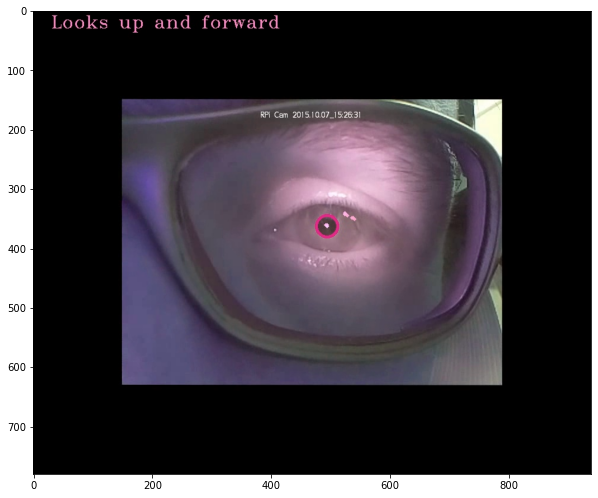

In [9]:
cap = cv2.VideoCapture('stable_P5_eyeTracking.mp4')
ret, F0 = cap.read()

x = []
y = []
time = 0
time=[]
t=0

# text and font manipulation
font_params = dict(org = (30,30),
                   fontFace = cv2.FONT_HERSHEY_TRIPLEX,
                   fontScale = 1,
                   color = (252,134,193),
                   lineType = 1)

# create a mask image for drawing purposes
canvas = np.zeros_like(F0)



while (1):
    ret ,F1 = cap.read()
    
    if ret == True:
        F1_gray = cv2.cvtColor(F1,cv2.COLOR_BGR2GRAY)
        F1_blur = cv2.GaussianBlur(F1_gray,(5,5),0)
        F1_edges = cv2.Canny(F1_blur,200,100)
        
        cv2.imshow('Black-white frame', F1_gray)
        cv2.imshow('Blurred frame',F1_blur)
        cv2.imshow('Edges of a frame',F1_edges)
        
        # HoughCircles to find pupil
        eye_circles = cv2.HoughCircles(F1_edges, method = cv2.HOUGH_GRADIENT, dp = 2, minDist=0.1, 
                                       param1=60, param2=20, minRadius=1, maxRadius=20)
        
        # marking relevant circle as pupil and its center
        for i in range(len(eye_circles)):
            if  eye_circles[0,i,0]< 650 and eye_circles[0,i,1]<450 and eye_circles[0,i,1]>170:
                cv2.circle(F1,
                           (int(eye_circles[0,i,0]),int(eye_circles[0,i,1])),
                           int(eye_circles[0,i,2]),
                           (229,41,135), 3)
                cv2.circle(canvas,
                           (int(eye_circles[0,i,0]), int(eye_circles[0,i,1])),
                           1, (252,134,193), 3)
                x.append(np.float32(eye_circles[0,i,0]))
                y.append(np.float32(eye_circles[0,i,1]))
                t=t+1
                time.append(t)
        
        
        # add some text:
        # assume that we are in place of person and not in front of him (like mirror), 
        # hence when we see that he's looking to the right he actually looks to the left
        cv2.putText(F1,'Looks' , **font_params)
        look_r = ' to the right'
        look_l = ' to the left'
        look_f = ' forward'
        current_look = ''
        if eye_circles[0,i,1] < eye_circles[0,1,1]-20:
            look_y = ' down and'
        elif eye_circles[0,i,1] > eye_circles[0,1,1]+60:
            look_y = ' up and'
        else:
            look_y = ''
        if eye_circles[0,i,0] < 480:
            if eye_circles[0,i,0] < eye_circles[0,i-1,0]:
                current_look = look_r
                cv2.putText(F1,'Looks '+ str(look_y) + str(current_look), **font_params)
        elif eye_circles[0,i,0] > 520:
            if eye_circles[0,i,0] > eye_circles[0,i-1,0]:
                current_look = look_l
                cv2.putText(F1,'Looks'+ str(look_y) + str(current_look), **font_params)
        else:
            current_look = look_f
            cv2.putText(F1,'Looks' + str(look_y) + str(current_look), **font_params)
        
        # visualize the results
        canvas = np.uint8(canvas*0.98) # fade out canvas  
        final = cv2.add(F1, canvas)
        
        cv2.imshow('Result with tracked pupil of an eye',final)
        cv2.imwrite('detected_pupil.jpg', final)
        if (cv2.waitKey(1) & 0xff == 27): # ESC key pressed?
            break
            
    else: # (ret==False)
        break
# screenshot of detected pupil and look direction
detected_pupil = cv2.imread('detected_pupil.jpg')
plt.imshow(detected_pupil)

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

# Pupil Trajectory

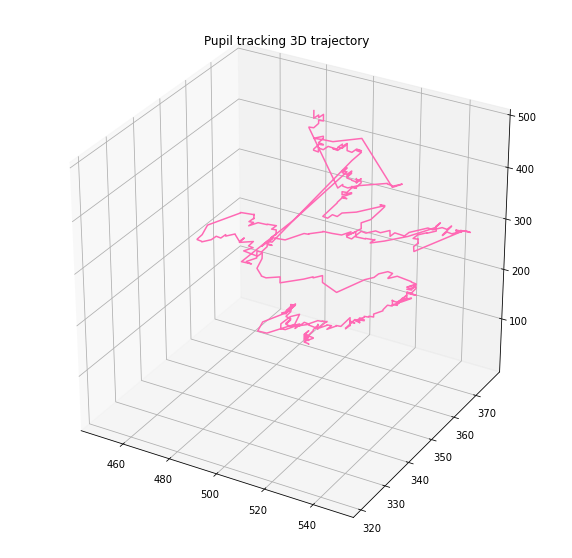

In [7]:
# reference to: https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")

# Data for a three-dimensional line
zline = time
xline = x
yline = y
ax.set_title('Pupil tracking 3D trajectory');
ax.plot3D(xline, yline, zline, "hotpink")
plt.show()